In [1]:
import pandas as pd
import numpy as np
import pickle, time
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
import umap, umap.plot

In [3]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": 'computer modern roman'})

In [4]:
def readEurostat(url): 
    df = pd.read_csv(url, sep="\s*\t\s*",index_col=0, engine="python").replace("^:",np.nan,regex=True).replace("\s[a-z]*$","",regex=True).astype(float)
    df.index = pd.MultiIndex.from_tuples([tuple(x.split(",")) for x in df.index], names=df.index.name.replace("\\","").split(","))
    return df

In [8]:
def makeFrame(eurostat_link, vars_of_interest, download, concat):
    # download indicators
    if concat:
        if download:
            downloads = {indicator:readEurostat(f'{eurostat_link}{indicator}.tsv.gz') for indicator in vars_of_interest}
            with open('data/downloads.pickle', 'wb') as handle: pickle.dump(downloads, handle)
            print('Download successful')
        else:
            with open('data/downloads.pickle', 'rb') as handle: downloads = pickle.load(handle)
        # concat tables
        table = pd.concat([pd.concat([downloads[table]], keys=[table], names=['file']).unstack(-1) for table in downloads if table in vars_of_interest]).T
        # fix index and columns
        table.index = ["_".join(pair) for pair in table.index]
        table.columns = ["-".join(pair) for pair in table.columns]
        table.to_csv('data/data.csv')
    else:
        with open('data/downloads.pickle', 'rb') as handle: downloads = pickle.load(handle)
        table = pd.read_csv('data/data.csv', index_col=0)
    return downloads, table

# Run

In [6]:
codes = pd.read_csv("codes.csv", index_col=0)

In [9]:
indicators = codes.index
link = "https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&downfile=data%2F";

In [ ]:
eurostat, data = makeFrame(link, indicators, False, False)

KeyboardInterrupt: 

In [47]:
def getNUTS(dataset):
    output = dataset.loc[(dataset.index.str.len()==10)&(dataset.index.str[0]=='2')].sort_index().copy()
    for var in output.index.str[-5:].unique():
        indeces = output.index.str[-5:] == var
        output.loc[indeces] = output.loc[indeces].interpolate(axis=0, fill_value="extrapolate", limit_direction="both")
    # ugly trick
    output = output.dropna(axis=1, how='all').drop_duplicates()
    output = output.fillna(output.mean())
    return output

In [48]:
nuts = getNUTS(data)

# Cluster

In [85]:
nuts=nuts.drop_duplicates()

In [ ]:
then = time.time()
mapper = umap.UMAP().fit(nuts)
now = time.time(); print("It took: ", now-then, " seconds")

/home/boturon/miniconda3/envs/econ/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


It took:  164.75934195518494  seconds


In [ ]:
nuts.index.str[5:7]

Index(['AL', 'AL', 'AL', 'AL', 'AL', 'AL', 'AL', 'AL', 'AL', 'AL',
       ...
       'TR', 'TR', 'TR', 'TR', 'TR', 'TR', 'TR', 'TR', 'TR', 'TR'],
      dtype='object', length=37139)

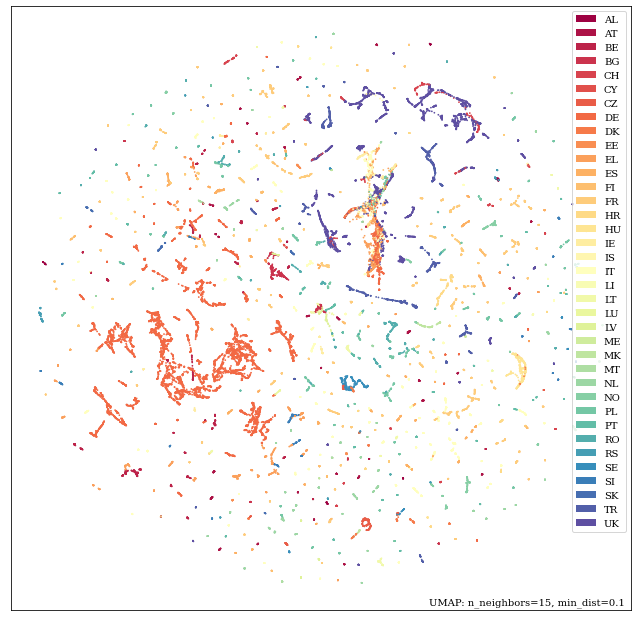

In [88]:
with mpl.rc_context({"text.usetex": False}):
    umap.plot.points(mapper, labels=nuts.index.str[5:7])

# Plots

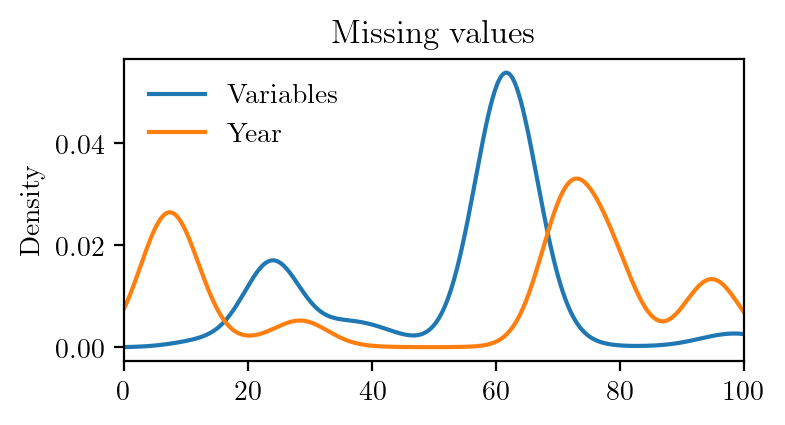

In [39]:
f, ax = plt.subplots(ncols=1, nrows=1, figsize=(4,2), dpi=200)
((nuts.isna()).sum()/nuts.shape[0]*100).plot.density(ax=ax)#.sum()#.index.str[5:7].value_counts()
((nuts.isna()).sum(axis=1)/nuts.shape[1]*100).plot.density(ax=ax)#.sum()#.index.str[5:7].value_counts()
plt.legend(['Variables', 'Year'], frameon=False); plt.xlim((0,100)); plt.title('Missing values'); plt.show()